In [28]:
# papermill parameters
zona = 31
class_label="Class_label_Jenks"
ruta = "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"


### IMPORTA LAS LIBRERÍAS

In [29]:
try:
    import lightgbm
    print("✅ lightgbm ya está instalado")
except ImportError:
    !pip install lightgbm


✅ lightgbm ya está instalado


In [30]:
try:
    import shap
    print("✅ shap ya está instalado")
except ImportError:
    !pip install shap


✅ shap ya está instalado


In [31]:

try:
    import optuna
    print("✅ optuna ya está instalado")
except ImportError:
    !pip install optuna

✅ optuna ya está instalado


In [32]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import lightgbm as lgb
import shap

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import seaborn as sns

import optuna

from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)

import json




### LECTURA DE DATAFRAME DE ENTRADA

In [33]:

# Leer el DataFrame de entrada

filename = f"Dataframe_caracteristicas_entrada_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

df = pd.read_pickle(output_file)

df.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Columns: 116 entries, FechaHora to Ccluster
dtypes: Int64(1), datetime64[ns](1), float64(110), geometry(1), object(3)
memory usage: 1.7+ MB


### AÑADIR COLUMNAS CON FECHA

In [34]:
# -------------------------
# 1. Características de fecha/hora (codificación cíclica)
# -------------------------
datetime_col = 'FechaHora'  
if datetime_col in df.columns:
    df["year"] = df[datetime_col].dt.year
    df["month"] = df[datetime_col].dt.month
    df["day"] = df[datetime_col].dt.day
    df["hour"] = df[datetime_col].dt.hour
    df["dayofweek"] = df[datetime_col].dt.dayofweek

    # codificación cíclica
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    # Eliminamos columnas originales de fecha si no las queremos como enteros
    #df = df.drop(columns=[datetime_col, "month", "hour", "dayofweek"]) 

print("Shape tras añadir datetime features:", df.shape)

Shape tras añadir datetime features: (1930, 127)


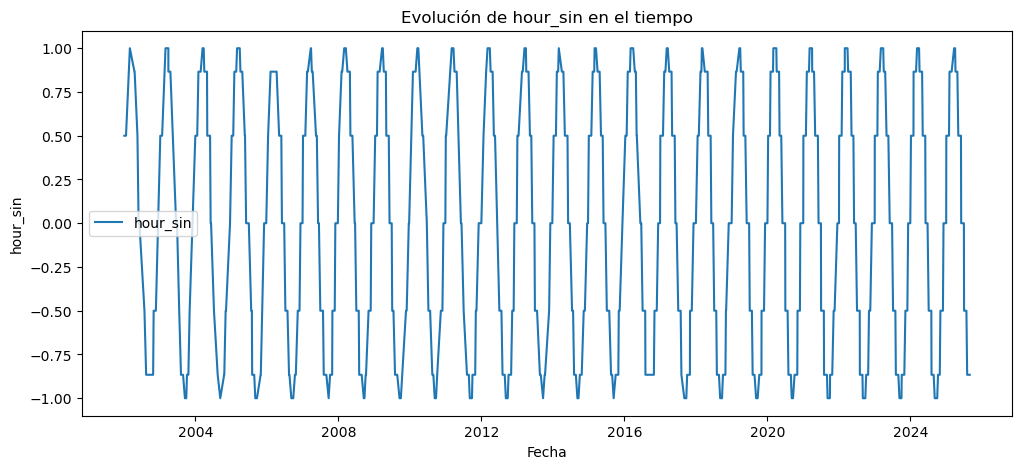

In [35]:

plt.figure(figsize=(12,5))
plt.plot(df['FechaHora'], df['month_sin'], label="hour_sin")
plt.xlabel("Fecha")
plt.ylabel("hour_sin")
plt.title("Evolución de hour_sin en el tiempo")
plt.legend()
plt.show()

### VECTOR DE ENTRADA: X
#### Dejar solo columnas numéricas

In [36]:
# Eliminamos columnas originales que no contienen información numérica
# Se define el vector de entrada

X = df.drop(columns=[datetime_col, 
                      "Evento",
                      "Latitud",
                      "Longitud",
                      "Inten",
                      "Mag",
                      "Tipo_Mag",
                      "Localizacion",
                      "FechaHora",
                      "geometry",
                      "Zona_ID",
                      "month",
                      "day",
                      "hour", 
                      "dayofweek"]) 

### LECTURA DE DATAFRAME DE SALIDA

In [37]:

# Leer el DataFrame de salida

filename = f"Datos_salida_clases_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

df_out = pd.read_pickle(output_file)

df_out.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Evento                 1930 non-null   object        
 1   Latitud                1930 non-null   float64       
 2   Longitud               1930 non-null   float64       
 3   Prof_Km                1930 non-null   float64       
 4   Inten                  1930 non-null   object        
 5   Mag                    1930 non-null   float64       
 6   Tipo_Mag               1930 non-null   Int64         
 7   Localizacion           1930 non-null   object        
 8   FechaHora              1930 non-null   datetime64[ns]
 9   Mag_mbLgL              1930 non-null   float64       
 10  geometry               1930 non-null   geometry      
 11  Zona_ID                1930 non-null   float64       
 12  Mmax_next30d           1930 non-null   float64       


### VECTOR DE SALIDA: y

In [38]:
y = df_out[class_label]
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1930 entries, 0 to 1929
Series name: Class_label_Jenks
Non-Null Count  Dtype
--------------  -----
1930 non-null   int64
dtypes: int64(1)
memory usage: 15.2 KB


### VECTORES DE ENTRENAMIENTO Y DE TEST

In [39]:
# Partición train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (1158, 113) Val: (386, 113) Test: (386, 113)


### PIPELINE DE PREPROCESAMIENTO

In [40]:
# =====================================================
# 1. Custom transformer para log1p en columnas sesgadas
# =====================================================
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0):
        self.skew_threshold = skew_threshold
        self.cols_to_log = []

    def fit(self, X, y=None):
        skewness = pd.DataFrame(X).skew()
        self.cols_to_log = skewness[skewness > self.skew_threshold].index.tolist()
        print(f"Columnas con log1p aplicado: {self.cols_to_log}")
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.cols_to_log:
            X[col] = np.log1p(np.clip(X[col], a_min=0, a_max=None))  # evitar negativos
        return X

# =====================================================
# 2. Pipeline de preprocesamiento
# =====================================================
def make_preprocessing_pipeline():
    pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("log_transform", LogTransformer(skew_threshold=1.0)),
        ("scaler", StandardScaler())
    ])
    return pipeline

### PREPROCESAMIENTO

In [41]:
# =====================================================
# 5. Preprocesamiento con pipeline
# =====================================================
pipeline = make_preprocessing_pipeline()

X_train_proc = pipeline.fit_transform(X_train)
X_val_proc   = pipeline.transform(X_val)
X_test_proc  = pipeline.transform(X_test)

# Convertimos de nuevo a DataFrame con nombres
X_train_proc = pd.DataFrame(X_train_proc, columns=X_train.columns, index=X_train.index)
X_val_proc   = pd.DataFrame(X_val_proc,   columns=X_val.columns,   index=X_val.index)
X_test_proc  = pd.DataFrame(X_test_proc,  columns=X_test.columns,  index=X_test.index)

print("Shape tras preprocessing:", X_train_proc.shape)

Columnas con log1p aplicado: [0, 1, 6, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 33, 34, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
Shape tras preprocessing: (1158, 113)


# MÉTODO LIGHTGBM

### SELECCIÓN DE CARACTERÍSTICAS

In [42]:
clf = lgb.LGBMClassifier(n_estimators=300, random_state=42)

evals_result = {}

clf.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    eval_metric=["multi_logloss", "multi_error"],  # <--- añadimos accuracy (multi_error)
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(50),
        lgb.record_evaluation(evals_result)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25408
[LightGBM] [Info] Number of data points in the train set: 1158, number of used features: 113
[LightGBM] [Info] Start training from score -1.536997
[LightGBM] [Info] Start training from score -0.905981
[LightGBM] [Info] Start training from score -1.219639
[LightGBM] [Info] Start training from score -2.459330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[50]	valid_0's multi_logloss: 0.609213	valid_0's multi_error: 0.233161
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.607024	valid_0's multi_error: 0.227979


LGBMClassifier(n_estimators=300, random_state=42)

In [43]:
# =====================================================
# 6. Selección de características con LightGBM
# =====================================================

clf = lgb.LGBMClassifier(n_estimators=300, random_state=42)

"""
import lightgbm as lgb

# Ejemplo de configuración optimizada para clasificación multiclase
clf = lgb.LGBMClassifier(
    boosting_type="gbdt",      # Gradient Boosted Decision Trees
    objective="multiclass",    # Objetivo multiclase
    num_class=4,               # Nº de clases (cámbialo según tu problema)
    
    # Control de complejidad
    n_estimators=1000,         # Más árboles que el default (100), pero con learning_rate bajo
    learning_rate=0.05,        # Menor que el default (0.1), más preciso y estable
    num_leaves=121,             # Complejidad del árbol (default = 31)
    max_depth=50,              # Sin límite, pero puedes fijar p.ej. 10 para evitar sobreajuste
    
    # Regularización
    min_child_samples=80,      # Default=20, subo para evitar hojas con muy pocos datos
    subsample=0.8,             # Bagging (default=1.0), introduce aleatoriedad
    subsample_freq=1,          # Cada iteración aplica el subsample
    colsample_bytree=0.8,      # Usa solo el 80% de las variables en cada árbol
    reg_alpha=0.1,             # Regularización L1
    reg_lambda=0.1,            # Regularización L2
    
    # Otros
    random_state=42,           # Reproducibilidad
    n_jobs=-1                  # Usa todos los núcleos disponibles
)

"""

evals_result = {}

clf.fit(
    X_train_proc, y_train,
#    eval_set=[(X_val_proc, y_val)],
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    eval_metric=["multi_logloss", "multi_error"],  # <--- añadimos accuracy (multi_error)
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(50),
        lgb.record_evaluation(evals_result)
    ]
)

# Selección automática de features
sfm = SelectFromModel(clf, prefit=True, threshold="median")
X_train_embedded = X_train_proc.loc[:, sfm.get_support()]
X_val_embedded   = X_val_proc.loc[:, sfm.get_support()]
X_test_embedded  = X_test_proc.loc[:, sfm.get_support()]

print("Características seleccionadas:", X_train_embedded.shape[1])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25408
[LightGBM] [Info] Number of data points in the train set: 1158, number of used features: 113
[LightGBM] [Info] Start training from score -1.536997
[LightGBM] [Info] Start training from score -0.905981
[LightGBM] [Info] Start training from score -1.219639
[LightGBM] [Info] Start training from score -2.459330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[50]	training's multi_logloss: 0.0387618	training's multi_error: 0	valid_1's multi_logloss: 0.609213	valid_1's multi_error: 0.233161
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.0467327	training's multi_error: 0	valid_1's multi_logloss: 0.607024	valid_1's mult

### CURVAS ERROR/PRECISIÓN DE ENTRENAMIENTO Y VALIDACIÓN

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

def plot_training_curves(clf, X_train, y_train, X_val, y_val, title="Curvas de entrenamiento LightGBM",output_file=None):
    """
    Dibuja la evolución del log loss y accuracy en entrenamiento y validación
    para un modelo LightGBM entrenado con la API sklearn.
    
    Parámetros:
    -----------
    clf     : objeto LGBMClassifier entrenado
    X_train : datos de entrenamiento
    y_train : etiquetas de entrenamiento
    X_val   : datos de validación
    y_val   : etiquetas de validación
    title   : título global del gráfico
    """
    
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    # Iteramos sobre cada número de árboles construido
    for i in range(1, clf.best_iteration_ + 1):
        # Probabilidades
        y_train_proba = clf.predict_proba(X_train, num_iteration=i)
        y_val_proba   = clf.predict_proba(X_val, num_iteration=i)
        
        # Log loss
        train_loss.append(log_loss(y_train, y_train_proba))
        val_loss.append(log_loss(y_val, y_val_proba))
        
        # Accuracy
        y_train_pred = np.argmax(y_train_proba, axis=1)
        y_val_pred   = np.argmax(y_val_proba, axis=1)
        train_acc.append(accuracy_score(y_train, y_train_pred))
        val_acc.append(accuracy_score(y_val, y_val_pred))

    # ===============================
    # Dibujar las curvas
    # ===============================
    epochs = range(1, clf.best_iteration_ + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loss
    ax[0].plot(epochs, train_loss, label="Entrenamiento")
    ax[0].plot(epochs, val_loss, label="Validación")
    ax[0].set_title("Evolución del error (*Loss*)")
    ax[0].set_xlabel("Iteraciones")
    ax[0].set_ylabel("Log Error (*Loss*)")
    ax[0].legend()

    # Accuracy
    ax[1].plot(epochs, train_acc, label="Entrenamiento")
    ax[1].plot(epochs, val_acc, label="Validación")
    ax[1].set_title("Evolución de la precisión (*Accuracy*)")
    ax[1].set_xlabel("Iteraciones")
    ax[1].set_ylabel("Precisión (*Accuracy*)")
    ax[1].legend()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()

    if output_file:
        fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
        fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)
    
    plt.show()


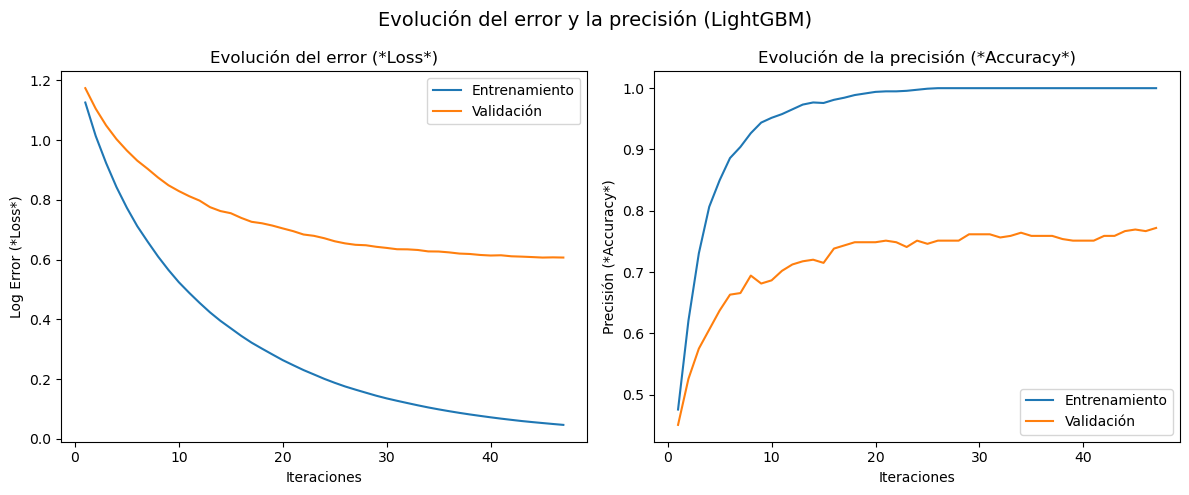

In [45]:
# Dibujar curvas

filename = f"Evolucion_Error_LightGBM_train_valid_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

plot_training_curves(clf, X_train_proc, y_train, X_val_proc, y_val,
                     title="Evolución del error y la precisión (LightGBM)",output_file=output_file)

### MATRIZ DE CONFUSIÓN

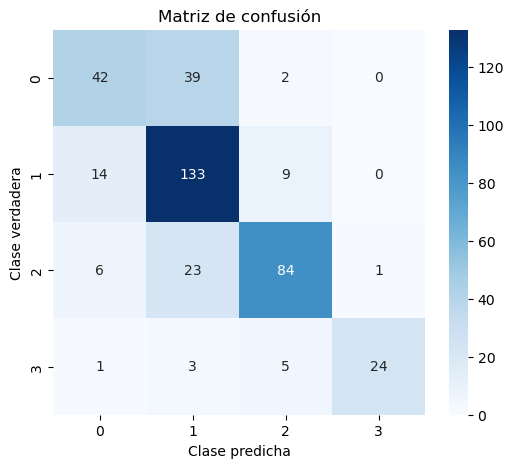


Informe de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.51      0.58        83
           1       0.67      0.85      0.75       156
           2       0.84      0.74      0.79       114
           3       0.96      0.73      0.83        33

    accuracy                           0.73       386
   macro avg       0.78      0.71      0.73       386
weighted avg       0.74      0.73      0.73       386



In [46]:
# =====================================================
# 3. Matriz de confusión
# =====================================================
y_pred = clf.predict(X_test_proc)

cm = confusion_matrix(y_test, y_pred)
fig=plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Clase predicha")
plt.ylabel("Clase verdadera")
plt.title("Matriz de confusión")

filename = f"Matriz_confusion_LightGBM_test_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

plt.show()

print("\nInforme de clasificación:\n", classification_report(y_test, y_pred))


### INFORME DE CLASIFICACIÓN

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def classification_report_with_specificity(y_true, y_pred, labels=None, target_names=None):
    # Reporte estándar
    report = classification_report(y_true, y_pred, output_dict=True, labels=labels, target_names=target_names)
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    n_classes = cm.shape[0]
    
    specificity = {}
    total_support = np.sum(cm, axis=1)
    
    # Especificidad por clase
    for i in range(n_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        report[str(i)]["specificity"] = specificity[i]
    
    # Macro average
    report["macro avg"]["specificity"] = np.mean(list(specificity.values()))
    
    # Weighted average
    report["weighted avg"]["specificity"] = np.average(
        list(specificity.values()), weights=total_support
    )
    
    return report


y_pred = clf.predict(X_test_proc)

report_ext = classification_report_with_specificity(y_test, y_pred)
import pandas as pd
df_report = pd.DataFrame(report_ext).T
print(df_report)

              precision    recall  f1-score     support  specificity
0              0.666667  0.506024  0.575342   83.000000     0.930693
1              0.671717  0.852564  0.751412  156.000000     0.717391
2              0.840000  0.736842  0.785047  114.000000     0.941176
3              0.960000  0.727273  0.827586   33.000000     0.997167
accuracy       0.733161  0.733161  0.733161    0.733161     0.733161
macro avg      0.784596  0.705676  0.734847  386.000000     0.896607
weighted avg   0.744977  0.733161  0.729999  386.000000     0.853267


### CURVA PRECISIÓN - SENSIBILIDAD

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize

def plot_pr_curves_with_f1(y_test, y_pred_proba, class_names=None, output_file=None):
    """
    Dibuja curvas Precision-Recall por clase, con PR-AUC y punto de F1 máximo.
    
    y_test: array (n_samples,) con etiquetas reales
    y_pred_proba: array (n_samples, n_classes) con probabilidades predichas
    class_names: lista con nombres de clases (opcional)
    """
    n_classes = y_pred_proba.shape[1]
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    fig=plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
        auc_score = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])

        # Calcular F1 para cada punto
        f1 = (2 * precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1)
        best_f1 = f1[best_idx]
        best_recall, best_precision = recall[best_idx], precision[best_idx]

        # Nombre de clase
        label = f"Clase {class_names[i] if class_names else i} (AUC={auc_score:.2f}, F1={best_f1:.2f})"

        # Dibujar curva
        plt.plot(recall, precision, lw=2, label=label)

        # Marcar punto óptimo
        plt.scatter(best_recall, best_precision, marker="o", s=60)

    plt.xlabel("Sensibilidad")
    plt.ylabel("Precisión")
    plt.title("Curva Precisión-Sensibilidad por clase (con punto F1 óptimo)")
    plt.legend(loc="lower left")
    
    # Fijar límites
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    
    plt.grid()

    fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
    fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)
    
    plt.show()




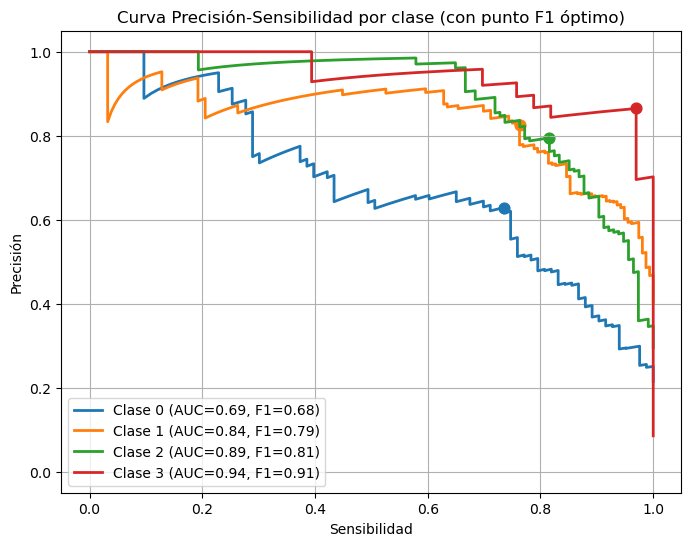

In [49]:
y_pred_proba = clf.predict_proba(X_test_proc)

filename = f"Curva_Precision_Sensibilidad_LightGBM_test_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

plot_pr_curves_with_f1(y_test, y_pred_proba, class_names=["0", "1", "2", "3"],output_file=output_file)


### CURVAS DE ENTRENAMIENTO

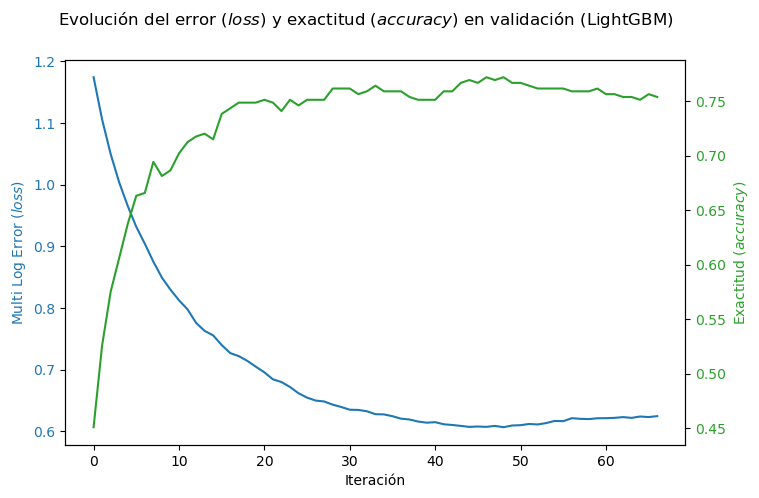

In [50]:
# =====================================================
# 2. Gráfico de evolución del loss y accuracy
# =====================================================
fig, ax1 = plt.subplots(figsize=(8,5))

# Curva de validación del loss
ax1.plot(evals_result['valid_1']['multi_logloss'], label="Val loss", color="tab:blue")
ax1.set_xlabel("Iteración")
ax1.set_ylabel("Multi Log Error ($\\it{loss}$)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Segundo eje para accuracy
ax2 = ax1.twinx()
val_acc = 1 - np.array(evals_result['valid_1']['multi_error'])  # multi_error = 1 - acc
ax2.plot(val_acc, label="Val accuracy", color="tab:green")
ax2.set_ylabel("Exactitud ($\\it{accuracy}$)", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

fig.suptitle("Evolución del error ($\\it{loss}$) y exactitud ($\\it{accuracy}$) en validación (LightGBM)")

filename = f"Curva_Loss_Accuracy_LightGBM_val_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

plt.show()

### CARACTERÍSTICAS SELECCIONADAS

In [51]:
# Nombres de las columnas seleccionadas
selected_features = X_train_proc.columns[sfm.get_support()]
print("Features seleccionadas:")
print(selected_features.tolist())


Features seleccionadas:
['Prof_Km', 'a_lsq', 'b_lsq', 'a_mlk', 'Tasa_Benioff', 'Tiempo_50_eventos', 'Mag_media_50', 'Mag_media_30d', 'Mag_std_30d', 'z_30d_eventos', 'MagMax_30d', 'MagMax_90d', 'ProfMedia_30d', 'TiempoDesdeUltimo', 'TiempoVentana_5Eventos', 'CoefVar_50Eventos', 'b_lsq_prob_M3.5', 'eta_T_lsq', 'eta_T_mlk', 'eta_N_lsq', 'eta_N_mlk', 'sigma_b_lsq_30d', 'sigma_b_mlk_30d', 'sigma_b_lsq_50ev', 'sigma_b_mlk_50ev', 'Mdef_evento_mlk', 'Mdef_Tdias_lsq', 'Mdef_Tdias_mlk', 'Mdef_Neventos_lsq', 'Mdef_Neventos_mlk', 'Trec_M3.5_lsq', 'Trec_M3.5_mlk', 'db_lsq_0_2', 'db_lsq_2_4', 'db_lsq_4_6', 'db_lsq_6_8', 'db_lsq_8_10', 'db_lsq_0_4', 'db_lsq_4_8', 'db_lsq_8_12', 'db_lsq_12_16', 'db_lsq_16_20', 'db_mlk_0_2', 'db_mlk_4_6', 'db_mlk_6_8', 'db_mlk_8_10', 'db_mlk_0_4', 'db_mlk_4_8', 'db_mlk_8_12', 'db_mlk_12_16', 'db_mlk_16_20', 'Ccluster', 'year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']


### CARACTERÍSTICAS MÁS IMPORTANTES

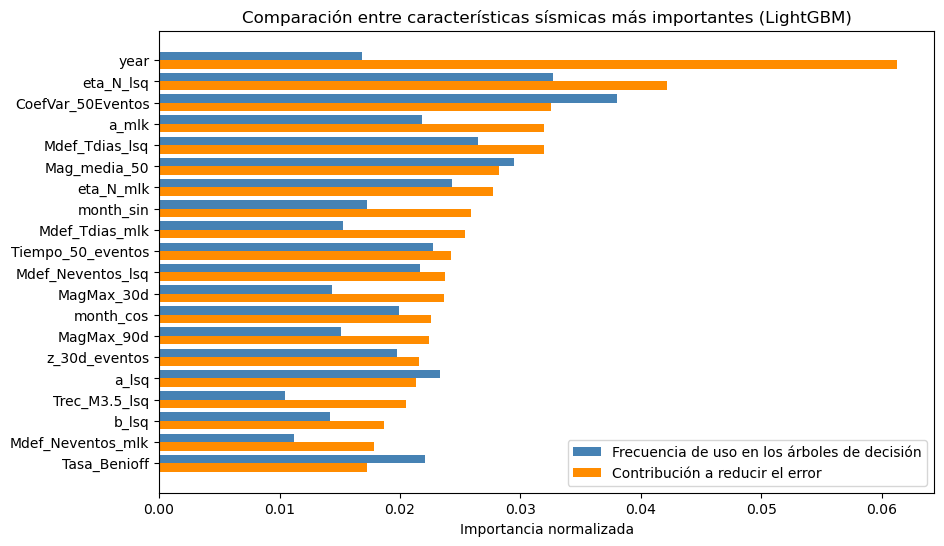

In [52]:


# Obtenemos las importancias
split_importance = clf.booster_.feature_importance(importance_type='split')
gain_importance = clf.booster_.feature_importance(importance_type='gain')

# Creamos un dataframe con ambas métricas
feat_imp = pd.DataFrame({
    "feature": clf.booster_.feature_name(),
    "split_importance": split_importance,
    "gain_importance": gain_importance
})

# Normalizamos para comparar en la misma escala
feat_imp["split_norm"] = feat_imp["split_importance"] / feat_imp["split_importance"].sum()
feat_imp["gain_norm"] = feat_imp["gain_importance"] / feat_imp["gain_importance"].sum()

# Ordenamos por gain para ver las más relevantes
feat_imp_sorted = feat_imp.sort_values("gain_norm", ascending=False).head(20)

# Posiciones para las barras
y = np.arange(len(feat_imp_sorted))
bar_width = 0.4  

fig=plt.figure(figsize=(10,6))

# Barras para split (azul)
plt.barh(y - bar_width/2, feat_imp_sorted["split_norm"], 
         height=bar_width, color="steelblue", label="Frecuencia de uso en los árboles de decisión")

# Barras para gain (naranja)
plt.barh(y + bar_width/2, feat_imp_sorted["gain_norm"], 
         height=bar_width, color="darkorange", label="Contribución a reducir el error")

# Etiquetas
plt.yticks(y, feat_imp_sorted["feature"])
plt.xlabel("Importancia normalizada")
plt.title("Comparación entre características sísmicas más importantes (LightGBM)")
plt.legend()
plt.gca().invert_yaxis()  # Para que la más importante quede arriba

filename = f"Caracteristicas_importantes_LightGBM_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

plt.show()




In [53]:

# Importancia de las 20 principales variables seleccionadas por LightGBM

# La métrica Gain refleja la contribución a la reducción de la pérdida
# Split indica la frecuencia de uso de la variable en las divisiones del modelo.")


# Importancias desde el booster interno
gain_importances = clf.booster_.feature_importance(importance_type='gain')
split_importances = clf.booster_.feature_importance(importance_type='split')
features = clf.booster_.feature_name()

# Construir DataFrame
feat_imp = pd.DataFrame({
    'Variable': features,
    'Gain': gain_importances,
    'Split': split_importances
})

# Normalización a porcentajes
feat_imp['Gain (%)'] = 100 * feat_imp['Gain'] / feat_imp['Gain'].sum()
feat_imp['Split (%)'] = 100 * feat_imp['Split'] / feat_imp['Split'].sum()

# Ordenar por importancia (Gain) y seleccionar top 20
feat_imp_sorted = feat_imp.sort_values(by="Gain (%)", ascending=False).head(20)

# Exportar a tabla tipo APA (sin tabulate)
table_txt = feat_imp_sorted[['Variable', 'Gain (%)', 'Split (%)']].to_string(
    index=False, float_format="%.2f"
)

print("=== Tabla APA (Texto plano) ===")
print(table_txt)




=== Tabla APA (Texto plano) ===
         Variable  Gain (%)  Split (%)
             year      6.13       1.69
        eta_N_lsq      4.22       3.27
CoefVar_50Eventos      3.25       3.80
            a_mlk      3.20       2.19
   Mdef_Tdias_lsq      3.19       2.65
     Mag_media_50      2.83       2.95
        eta_N_mlk      2.77       2.43
        month_sin      2.59       1.72
   Mdef_Tdias_mlk      2.54       1.53
Tiempo_50_eventos      2.42       2.27
Mdef_Neventos_lsq      2.37       2.17
       MagMax_30d      2.37       1.44
        month_cos      2.26       1.99
       MagMax_90d      2.24       1.51
    z_30d_eventos      2.16       1.97
            a_lsq      2.13       2.33
    Trec_M3.5_lsq      2.05       1.05
            b_lsq      1.87       1.42
Mdef_Neventos_mlk      1.78       1.12
     Tasa_Benioff      1.72       2.20
